# 1. Load data

In [1]:
# Import library
import pandas as pd

In [2]:
# Load data     ####################################################################################################################
filepath_data = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\data_preprocessed.csv'

with open(filepath_data, 'rb') as fp:
    df = pd.read_csv(fp)

In [3]:
# Check data shape
df.shape

(10641, 19)

In [4]:
# Check data
df.head()

,HasChildDiedU5,ChildSex,Residence,Education,DeliveryByCaesareanSection,PostnatalCareVisits,Region,WealthIndex,WaterSource,ToiletFacility,PlaceOfDelivery,ContraceptiveUse,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,HouseholdSize,TimeToWaterSource,BreastFed,AntenatalCareVisits
0,0.0,Male,Rural,No education,No,No,Oromia,Low,improved,unimproved,home,no,8,15,38,11,45.0,Greater than an hour of birth,No visit
1,0.0,Male,Rural,No education,No,NaN,Oromia,Low,improved,unimproved,home,no,7,15,38,11,45.0,Greater than an hour of birth,NaN
2,0.0,Female,Rural,No education,No,NaN,Oromia,Low,improved,unimproved,home,no,6,15,38,11,45.0,Greater than an hour of birth,NaN
3,1.0,Male,Rural,Primary,No,No,Oromia,Low,improved,unimproved,home,no,8,24,42,8,30.0,Greater than an hour of birth,No visit
4,0.0,Male,Rural,No education,No,No,Oromia,Low,improved,improved,home,no,12,21,46,11,40.0,Within an hour of birth,No visit


In [5]:
# Load schema definiton     ####################################################################################################################
filepath_data = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\schema_definition_preprocessed.csv'

with open(filepath_data, 'rb') as fp:
    schema_definition = pd.read_csv(fp)

In [6]:
schema_definition

,VariableName,VariableCode,VariableType,Query
0,HasChildDiedU5,"B7, B8, B13, B19, HW1",label,"select * from "".\ET_2016_DHS_07082021_1932_581..."
1,ChildSex,B4,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
2,BirthOrder,BORD,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."
3,MotherAgeAtFirstBirth,V212,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."
4,AgeOfMother,V012,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."
5,Residence,V025,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
6,Education,V106,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
7,WealthIndex,V190,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
8,WaterSource,V113,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
9,TimeToWaterSource,V115,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."


# 2. Explore data (EDA)

In [7]:
# Import library
from ydata_profiling import ProfileReport

In [8]:
# Generate EDA report
profile_report = ProfileReport(df, title="DHS U5 Mortality", minimal=True)

In [9]:
# Display EDA report
profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### FINDINGS according to the EDA report

* Issues
    * WaterSource: #missing values = 133
    * ToiletFacility: #missing values = 133
    * TimeToWaterSource: #missing values = 182
    * BreastFed: #missing values = 403
    * AntenatalCareVisits: #missing values = 3,467
* Conclusion:
    * Possible to impute all variabels, although AnetenatalCareVisits variable imputation should be done carefully!

# 3. Build Machine Learning (ML) models

## 3.1 Split data into training / validation sets

In [10]:
# Get label and features
X = df.drop(['HasChildDiedU5'], axis='columns')
y = df[['HasChildDiedU5']]

In [11]:
# Check data
X.head()

,ChildSex,Residence,Education,DeliveryByCaesareanSection,PostnatalCareVisits,Region,WealthIndex,WaterSource,ToiletFacility,PlaceOfDelivery,ContraceptiveUse,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,HouseholdSize,TimeToWaterSource,BreastFed,AntenatalCareVisits
0,Male,Rural,No education,No,No,Oromia,Low,improved,unimproved,home,no,8,15,38,11,45.0,Greater than an hour of birth,No visit
1,Male,Rural,No education,No,NaN,Oromia,Low,improved,unimproved,home,no,7,15,38,11,45.0,Greater than an hour of birth,NaN
2,Female,Rural,No education,No,NaN,Oromia,Low,improved,unimproved,home,no,6,15,38,11,45.0,Greater than an hour of birth,NaN
3,Male,Rural,Primary,No,No,Oromia,Low,improved,unimproved,home,no,8,24,42,8,30.0,Greater than an hour of birth,No visit
4,Male,Rural,No education,No,No,Oromia,Low,improved,improved,home,no,12,21,46,11,40.0,Within an hour of birth,No visit


In [12]:
y.head()

,HasChildDiedU5
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


In [13]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

RANDOM_STATE = 101
TEST_SIZE = 0.20

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, 
                                                  test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Sanity checks
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('\n')
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('\n')
print('Mortality rate (TRAIN):\n', y_train['HasChildDiedU5'].value_counts(dropna=False, normalize=True).round(2) * 100)
print('\nMortality rate (VAL):\n', y_val['HasChildDiedU5'].value_counts(dropna=False, normalize=True).round(2) * 100)

X_train (8512, 18)
y_train (8512, 1)


X_val (2129, 18)
y_val (2129, 1)


Mortality rate (TRAIN):
 0.0    94.0
1.0     6.0
Name: HasChildDiedU5, dtype: float64

Mortality rate (VAL):
 0.0    94.0
1.0     6.0
Name: HasChildDiedU5, dtype: float64


## 3.2 Impute missing values

In [14]:
# Split data further into numeric and categorical features    ##########################################################################
# First, get numeric and categorical features from schema definition
schema_definition.head()

,VariableName,VariableCode,VariableType,Query
0,HasChildDiedU5,"B7, B8, B13, B19, HW1",label,"select * from "".\ET_2016_DHS_07082021_1932_581..."
1,ChildSex,B4,feature_categorical,"select * from "".\ET_2016_DHS_07082021_1932_581..."
2,BirthOrder,BORD,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."
3,MotherAgeAtFirstBirth,V212,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."
4,AgeOfMother,V012,feature_numeric,"select * from "".\ET_2016_DHS_07082021_1932_581..."


In [15]:
# First, get numeric and categorical features from schema definition
features_cat = schema_definition[schema_definition['VariableType'] == 'feature_categorical']['VariableName'].to_list()
features_num = schema_definition[schema_definition['VariableType'] == 'feature_numeric']['VariableName'].to_list()

print('features_cat\n', features_cat)
print('features_num\n', features_num)

features_cat
 ['ChildSex', 'Residence', 'Education', 'WealthIndex', 'WaterSource', 'ToiletFacility', 'PlaceOfDelivery', 'DeliveryByCaesareanSection', 'ContraceptiveUse', 'AntenatalCareVisits', 'PostnatalCareVisits', 'Region', 'BreastFed']
features_num
 ['BirthOrder', 'MotherAgeAtFirstBirth', 'AgeOfMother', 'TimeToWaterSource', 'HouseholdSize']


In [16]:
# Get data by feature type
X_train_cat = X_train[features_cat]
X_val_cat = X_val[features_cat]

X_train_num = X_train[features_num]
X_val_num = X_val[features_num]

In [17]:
X_train_cat.head()

,ChildSex,Residence,Education,WealthIndex,WaterSource,ToiletFacility,PlaceOfDelivery,DeliveryByCaesareanSection,ContraceptiveUse,AntenatalCareVisits,PostnatalCareVisits,Region,BreastFed
2736,Female,Rural,No education,Middle,unimproved,unimproved,home,No,no,NaN,NaN,Amhara,Greater than an hour of birth
9537,Female,Rural,Primary,Low,improved,unimproved,health_center,No,yes,1 - 4 visits,No,Tigray,Greater than an hour of birth
5962,Male,Rural,No education,Low,improved,unimproved,home,No,no,5+ visits,No,SNNPR,Within an hour of birth
5466,Female,Rural,Higher,Low,unimproved,unimproved,home,No,no,No visit,No,Gambela,Within an hour of birth
8908,Female,Rural,Primary,Low,NaN,NaN,home,No,no,1 - 4 visits,No,Tigray,Within an hour of birth


In [18]:
X_train_num.head()

,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,TimeToWaterSource,HouseholdSize
2736,4,17,35,30.0,9
9537,1,17,20,30.0,7
5962,5,18,35,20.0,7
5466,4,21,38,5.0,3
8908,1,17,18,NaN,17


In [19]:
# Check missing data in categorical features
X_train_cat.isnull().sum()

ChildSex                         0
Residence                        0
Education                        0
WealthIndex                      0
WaterSource                    109
ToiletFacility                 109
PlaceOfDelivery                  0
DeliveryByCaesareanSection       0
ContraceptiveUse                 0
AntenatalCareVisits           2777
PostnatalCareVisits           2763
Region                           0
BreastFed                      337
dtype: int64

In [20]:
# Check missing data in numeric features
X_train_num.isnull().sum()

BirthOrder                 0
MotherAgeAtFirstBirth      0
AgeOfMother                0
TimeToWaterSource        147
HouseholdSize              0
dtype: int64

In [21]:
# Impute categorical features     ###############################################################################################################
# Import library
from sklearn.impute import SimpleImputer

# Apply imputer
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train_cat_imputed = imputer_cat.fit_transform(X_train_cat)
X_train_cat_imputed = pd.DataFrame(X_train_cat_imputed, columns=X_train_cat.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_train_cat.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_train_cat_imputed.isnull().sum())

Number of missing values (BEFORE):
 ChildSex                         0
Residence                        0
Education                        0
WealthIndex                      0
WaterSource                    109
ToiletFacility                 109
PlaceOfDelivery                  0
DeliveryByCaesareanSection       0
ContraceptiveUse                 0
AntenatalCareVisits           2777
PostnatalCareVisits           2763
Region                           0
BreastFed                      337
dtype: int64

Number of missing values (AFTER):
 ChildSex                      0
Residence                     0
Education                     0
WealthIndex                   0
WaterSource                   0
ToiletFacility                0
PlaceOfDelivery               0
DeliveryByCaesareanSection    0
ContraceptiveUse              0
AntenatalCareVisits           0
PostnatalCareVisits           0
Region                        0
BreastFed                     0
dtype: int64


In [22]:
# Impute validation set as well
X_val_cat_imputed = imputer_cat.transform(X_val_cat)
X_val_cat_imputed = pd.DataFrame(X_val_cat_imputed, columns=X_val_cat.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_val_cat.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_val_cat_imputed.isnull().sum())

Number of missing values (BEFORE):
 ChildSex                        0
Residence                       0
Education                       0
WealthIndex                     0
WaterSource                    24
ToiletFacility                 24
PlaceOfDelivery                 0
DeliveryByCaesareanSection      0
ContraceptiveUse                0
AntenatalCareVisits           690
PostnatalCareVisits           690
Region                          0
BreastFed                      66
dtype: int64

Number of missing values (AFTER):
 ChildSex                      0
Residence                     0
Education                     0
WealthIndex                   0
WaterSource                   0
ToiletFacility                0
PlaceOfDelivery               0
DeliveryByCaesareanSection    0
ContraceptiveUse              0
AntenatalCareVisits           0
PostnatalCareVisits           0
Region                        0
BreastFed                     0
dtype: int64


In [23]:
# Impute numeric features     ###############################################################################################################
imputer_num = SimpleImputer(strategy='median')

X_train_num_imputed = imputer_num.fit_transform(X_train_num)
X_train_num_imputed = pd.DataFrame(X_train_num_imputed, columns=X_train_num.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_train_num.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_train_num_imputed.isnull().sum())

Number of missing values (BEFORE):
 BirthOrder                 0
MotherAgeAtFirstBirth      0
AgeOfMother                0
TimeToWaterSource        147
HouseholdSize              0
dtype: int64

Number of missing values (AFTER):
 BirthOrder               0
MotherAgeAtFirstBirth    0
AgeOfMother              0
TimeToWaterSource        0
HouseholdSize            0
dtype: int64


In [24]:
# Impute validation set as well
X_val_num_imputed = imputer_num.transform(X_val_num)
X_val_num_imputed = pd.DataFrame(X_val_num_imputed, columns=X_val_num.columns)

# Sanity checks
print('Number of missing values (BEFORE):\n', X_val_num.isnull().sum())
print('\nNumber of missing values (AFTER):\n', X_val_num_imputed.isnull().sum())

Number of missing values (BEFORE):
 BirthOrder                0
MotherAgeAtFirstBirth     0
AgeOfMother               0
TimeToWaterSource        35
HouseholdSize             0
dtype: int64

Number of missing values (AFTER):
 BirthOrder               0
MotherAgeAtFirstBirth    0
AgeOfMother              0
TimeToWaterSource        0
HouseholdSize            0
dtype: int64


In [25]:
# Save imputers for future use   ####################################################################################################

# Import library
import pickle
    
filepath_imputer_cat = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\imputer_cat.pkl'
with open(filepath_imputer_cat, 'wb') as pkl:
    pickle.dump(imputer_cat, pkl)

filepath_imputer_num = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\imputer_num.pkl'
with open(filepath_imputer_num, 'wb') as pkl:
    pickle.dump(imputer_num, pkl)

## 3.3 Feature scaling or normalization for numeric features

In [26]:
# Feature scaling for numeric variables   ############################################################################################

# Import library
from sklearn.preprocessing import StandardScaler

# Apply feature scaling
scaler = StandardScaler()

X_train_num_scaler = scaler.fit_transform(X_train_num_imputed)
X_train_num_scaler = pd.DataFrame(X_train_num_scaler, columns=X_train_num_imputed.columns)

# Sanity checks
X_train_num_scaler.head()

,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,TimeToWaterSource,HouseholdSize
0,0.051289,-0.565154,0.884864,-0.242923,1.307274
1,-1.145886,-0.565154,-1.411793,-0.242923,0.428046
2,0.450347,-0.291685,0.884864,-0.379912,0.428046
3,0.051289,0.528722,1.344196,-0.585396,-1.330412
4,-1.145886,-0.565154,-1.718014,-0.242923,4.824190


In [27]:
# Scale validation data as well
X_val_num_scaler = scaler.transform(X_val_num_imputed)
X_val_num_scaler = pd.DataFrame(X_val_num_scaler, columns=X_val_num_imputed.columns)

# Sanity checks
X_val_num_scaler.head()

,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,TimeToWaterSource,HouseholdSize
0,1.248463,0.802191,1.191085,4.277726,0.867660
1,-1.145886,-0.838623,-1.718014,0.168045,-1.770026
2,-0.347770,-0.018216,0.578643,-0.653891,-0.890798
3,1.248463,-1.112092,0.578643,2.633854,0.867660
4,0.849405,-0.018216,1.191085,0.989981,0.428046


In [28]:
# Save scaler for later use
filepath_scaler = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\scaler.pkl'
with open(filepath_scaler, 'wb') as pkl:
    pickle.dump(scaler, pkl)

## 3.4 One-Hot Encoding for categorical features

In [29]:
# Check data before Encoding!
X_train_cat_imputed.head()

,ChildSex,Residence,Education,WealthIndex,WaterSource,ToiletFacility,PlaceOfDelivery,DeliveryByCaesareanSection,ContraceptiveUse,AntenatalCareVisits,PostnatalCareVisits,Region,BreastFed
0,Female,Rural,No education,Middle,unimproved,unimproved,home,No,no,1 - 4 visits,No,Amhara,Greater than an hour of birth
1,Female,Rural,Primary,Low,improved,unimproved,health_center,No,yes,1 - 4 visits,No,Tigray,Greater than an hour of birth
2,Male,Rural,No education,Low,improved,unimproved,home,No,no,5+ visits,No,SNNPR,Within an hour of birth
3,Female,Rural,Higher,Low,unimproved,unimproved,home,No,no,No visit,No,Gambela,Within an hour of birth
4,Female,Rural,Primary,Low,improved,unimproved,home,No,no,1 - 4 visits,No,Tigray,Within an hour of birth


In [30]:
# Import library
from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_cat_encoded = encoder.fit_transform(X_train_cat_imputed)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# Sanity checks after Encoding!
X_train_cat_encoded.head()

,ChildSex_Female,ChildSex_Male,Residence_Rural,Residence_Urban,Education_Higher,Education_No education,Education_Primary,Education_Secondary,WealthIndex_High,WealthIndex_Low,...,Region_Benishangul,Region_Dire Dawa,Region_Gambela,Region_Harari,Region_Oromia,Region_SNNPR,Region_Somali,Region_Tigray,BreastFed_Greater than an hour of birth,BreastFed_Within an hour of birth
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [31]:
# Encode validation data set as well
X_val_cat_encoded = encoder.transform(X_val_cat_imputed)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# Sanity checks after Encoding!
X_val_cat_encoded.head()

,ChildSex_Female,ChildSex_Male,Residence_Rural,Residence_Urban,Education_Higher,Education_No education,Education_Primary,Education_Secondary,WealthIndex_High,WealthIndex_Low,...,Region_Benishangul,Region_Dire Dawa,Region_Gambela,Region_Harari,Region_Oromia,Region_SNNPR,Region_Somali,Region_Tigray,BreastFed_Greater than an hour of birth,BreastFed_Within an hour of birth
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [32]:
# Save encoder for later use
filepath_encoder = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\encoder.pkl'
with open(filepath_encoder, 'wb') as pkl:
    pickle.dump(encoder, pkl)

## 3.5 Combine processed data

In [33]:
# Combine data - TRAIN
X_train_ready = pd.concat([X_train_num_scaler, X_train_cat_encoded], axis='columns')

print('X_train_ready', X_train_ready.shape)
print('\n')

X_train_ready.head()

X_train_ready (8512, 47)




,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,TimeToWaterSource,HouseholdSize,ChildSex_Female,ChildSex_Male,Residence_Rural,Residence_Urban,Education_Higher,...,Region_Benishangul,Region_Dire Dawa,Region_Gambela,Region_Harari,Region_Oromia,Region_SNNPR,Region_Somali,Region_Tigray,BreastFed_Greater than an hour of birth,BreastFed_Within an hour of birth
0,0.051289,-0.565154,0.884864,-0.242923,1.307274,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.145886,-0.565154,-1.411793,-0.242923,0.428046,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.450347,-0.291685,0.884864,-0.379912,0.428046,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.051289,0.528722,1.344196,-0.585396,-1.330412,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.145886,-0.565154,-1.718014,-0.242923,4.824190,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [34]:
# Combine data - VALIDATION
X_val_ready = pd.concat([X_val_num_scaler, X_val_cat_encoded], axis='columns')

print('X_val_ready', X_val_ready.shape)
print('\n')

X_val_ready.head()

X_val_ready (2129, 47)




,BirthOrder,MotherAgeAtFirstBirth,AgeOfMother,TimeToWaterSource,HouseholdSize,ChildSex_Female,ChildSex_Male,Residence_Rural,Residence_Urban,Education_Higher,...,Region_Benishangul,Region_Dire Dawa,Region_Gambela,Region_Harari,Region_Oromia,Region_SNNPR,Region_Somali,Region_Tigray,BreastFed_Greater than an hour of birth,BreastFed_Within an hour of birth
0,1.248463,0.802191,1.191085,4.277726,0.867660,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-1.145886,-0.838623,-1.718014,0.168045,-1.770026,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.347770,-0.018216,0.578643,-0.653891,-0.890798,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.248463,-1.112092,0.578643,2.633854,0.867660,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.849405,-0.018216,1.191085,0.989981,0.428046,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 3.6 Build ML models

In [35]:
# Convert label from Pandas data frame to numpy for ML training
y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()

In [36]:
y_train.shape

(8512,)

In [37]:
type(y_train)

numpy.ndarray

In [38]:
y_train[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### General Linear Model (Logistic regression model)

In [39]:
# Import library
from sklearn.linear_model import LogisticRegression

# Train ML model
RANDOM_STATE = 101

model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

model_lr.fit(X_train_ready, y_train)

LogisticRegression(max_iter=1000, random_state=101)

In [40]:
# Evaluate model
y_pred_lr = model_lr.predict(X_val_ready)

In [41]:
y_pred_lr[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
# Evaluate model performance using Confusion matrix and ROC #################################################################################################
from sklearn.metrics import confusion_matrix

# Get confusion matrix
confusion_matrix(y_true=y_val, y_pred=y_pred_lr)

array([[2002,    0],
       [ 127,    0]], dtype=int64)

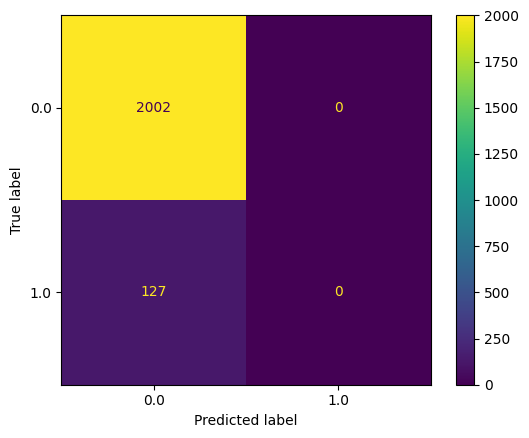

In [43]:
# Display confusion matrix
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=model_lr.classes_)
disp.plot()

plt.show()

In [44]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

# Calculate prediction probability before calculating AUC
y_pred_prob_lr = model_lr.predict_proba(X_val_ready)
print('y_pred_prob_lr\n', y_pred_prob_lr[:10])

y_pred_prob_lr
 [[0.93562421 0.06437579]
 [0.77937415 0.22062585]
 [0.87193844 0.12806156]
 [0.97746281 0.02253719]
 [0.95205935 0.04794065]
 [0.94650013 0.05349987]
 [0.96940348 0.03059652]
 [0.97330231 0.02669769]
 [0.87767223 0.12232777]
 [0.95201944 0.04798056]]


In [45]:
auc_lr = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr

0.6834504078598567

In [46]:
# Plot ROC
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

In [47]:
# Custom function to plot ROC curve
def plot_roc_curve(fpr_list, tpr_list, label_list=None, auc_list=None):  
    assert isinstance(fpr_list, list), 'Please pass FPR in a list, e.g., [fpr_lr]'
    assert isinstance(tpr_list, list), 'Please pass TPR in a list, e.g., [fpr_lr]'
    
    if label_list is not None:
        assert isinstance(label_list, list), 'Please pass label in a list, e.g., [label_lr]'
        
    if auc_list is not None:
        assert isinstance(auc_list, list), 'Please pass AUC in a list, e.g., [auc_lr]'
    
    if label_list is None:
        label_list = [None] * len(fpr_list)
        
    if auc_list is None:
        auc_list = [None] * len(fpr_list)
        
    for fpr, tpr, label, auc in zip(fpr_list, tpr_list, label_list, auc_list):
        plt.plot(fpr, tpr, linewidth=2, 
                 label=''.join([label, ' (auc = ', str(round(auc * 100, 1)), '%)']) if label is not None else None,
                )
        plt.plot([0, 1], [0, 1], color='0.8')

        plt.xlabel("FPR (1 - Specificity)")
        plt.ylabel("TPR (Sensitivity)")
        
        if label is not None and auc is not None:
            plt.legend()

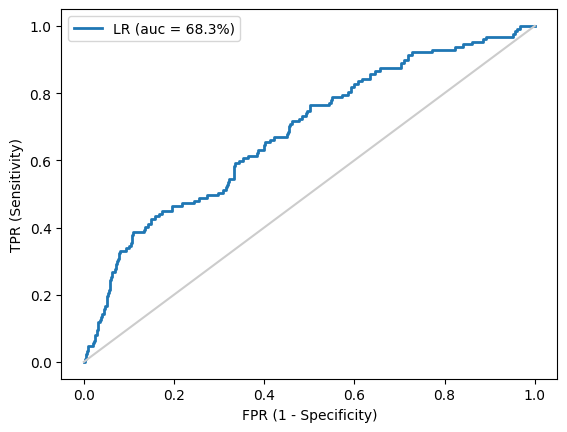

In [48]:
# Plot ROC for logistic regression model
plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr])

### Random Forest Model

In [49]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Set Hyperparameters
N_TREES = 250
N_DEPTH = 3

# Train model
model_rf = RandomForestClassifier(n_estimators=N_TREES, max_depth=N_DEPTH, random_state=RANDOM_STATE)

model_rf.fit(X_train_ready, y_train)

RandomForestClassifier(max_depth=3, n_estimators=250, random_state=101)

In [50]:
# Evaluate model
y_pred_rf = model_rf.predict(X_val_ready)

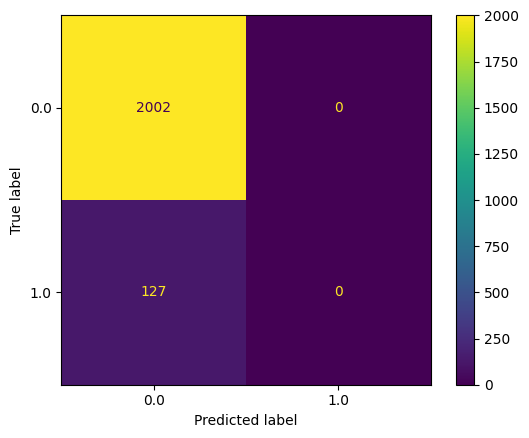

In [51]:
# Display confusion matrix
cm_rf = confusion_matrix(y_true=y_val, y_pred=y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp.plot()

plt.show()

In [52]:
# Calculate AUC
y_pred_prob_rf = model_rf.predict_proba(X_val_ready)

auc_rf = roc_auc_score(y_val, y_pred_prob_rf[:, -1])
auc_rf

0.6549218498037397

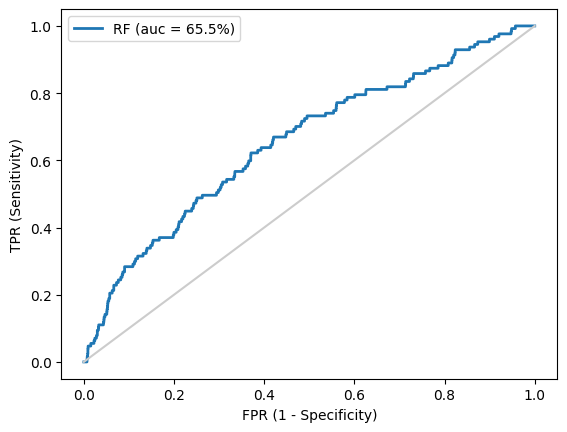

In [53]:
# ROC for RF
fpr_rf, tpr_rf, th_rf = roc_curve(y_val, y_pred_prob_rf[:, -1])

plot_roc_curve([fpr_rf], [tpr_rf], label_list=['RF'], auc_list=[auc_rf])

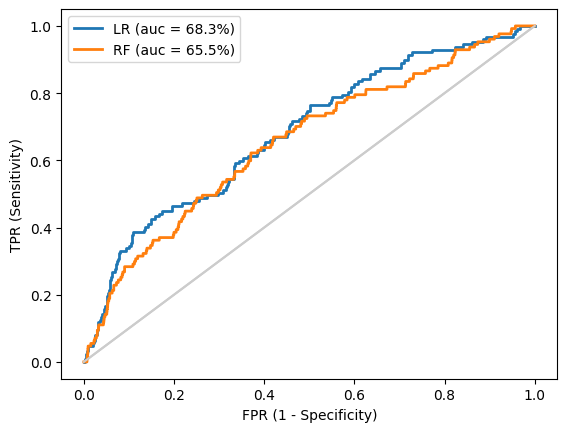

In [54]:
# Compare models
plot_roc_curve([fpr_lr, fpr_rf], [tpr_lr, tpr_rf], label_list=['LR', 'RF'], auc_list=[auc_lr, auc_rf])

### Gradient Boosting - Catboost

In [55]:
# Import library
from catboost import CatBoostClassifier

# Set Hyperparameters
N_TREES = 250
LEARNING_RATE = 0.001
N_DEPTH = 5

# Train model
model_cb = CatBoostClassifier(iterations=N_TREES,
                              learning_rate=LEARNING_RATE,
                              depth=N_DEPTH, 
                              verbose=0)
# Fit model
model_cb.fit(X_train_ready, y_train)

In [56]:
# Evaluate model
y_pred_cb = model_cb.predict(X_val_ready)

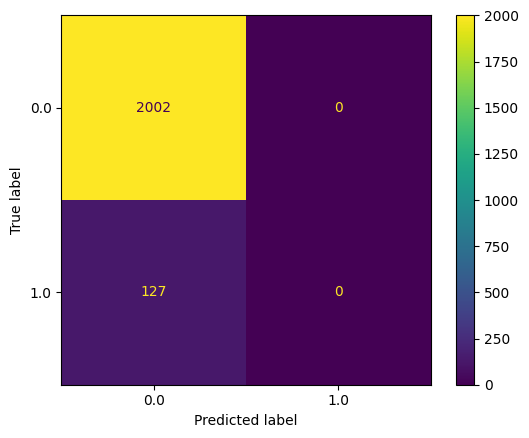

In [57]:
# Display confusion matrix
cm_cb = confusion_matrix(y_true=y_val, y_pred=y_pred_cb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=model_cb.classes_)
disp.plot()

plt.show()

In [58]:
# Calculate AUC
y_pred_prob_cb = model_cb.predict_proba(X_val_ready)

auc_cb = roc_auc_score(y_val, y_pred_prob_cb[:, -1])
auc_cb

0.6446152272923926

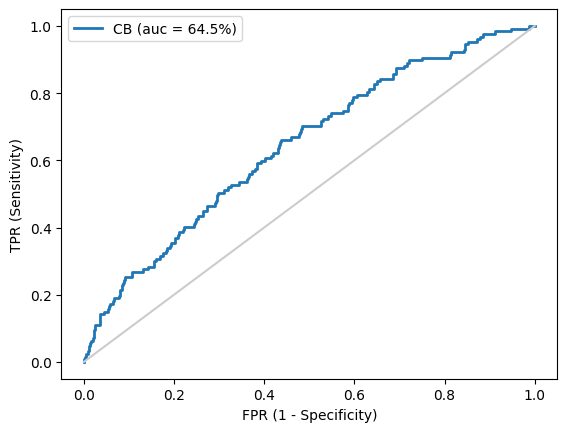

In [59]:
# ROC for RF
fpr_cb, tpr_cb, th_cb = roc_curve(y_val, y_pred_prob_cb[:, -1])

plot_roc_curve([fpr_cb], [tpr_cb], label_list=['CB'], auc_list=[auc_cb])

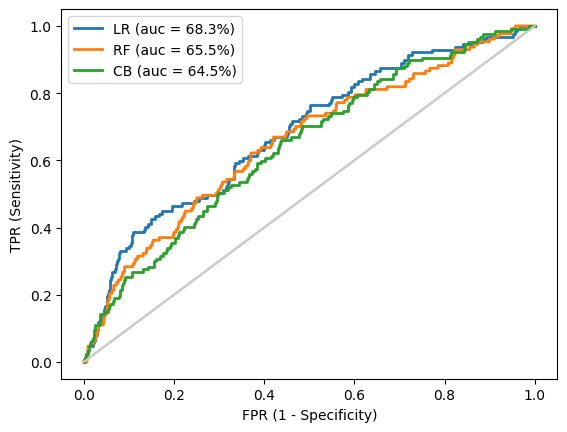

In [60]:
# Compare models
plot_roc_curve([fpr_lr, fpr_rf, fpr_cb], [tpr_lr, tpr_rf, tpr_cb], label_list=['LR', 'RF', 'CB'], auc_list=[auc_lr, auc_rf, auc_cb])

# 4. Improve model performance

## 4.1 Address class imbalance

In [61]:
y_train_df = pd.DataFrame({
    'target': y_train
})

y_train_df

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8507,0.0
8508,0.0
8509,0.0
8510,1.0


In [62]:
# combine X_train and y_train into a single DataFrame
y_train_df = pd.DataFrame({
    'target': y_train
})

train_data = pd.concat([X_train_ready, y_train_df], axis=1)

# separate instances of each class
negative_class = train_data[train_data.target==0]
positive_class = train_data[train_data.target==1]

# randomly undersample the majority class
from sklearn.utils import resample

RANDOM_STATE = 101

negative_class_downsampled = resample(negative_class,
                                       replace=False,     # sample without replacement
                                       n_samples=len(positive_class),  # match minority class
                                       random_state=RANDOM_STATE)   # reproducible results

# combine minority class and downsampled majority class
downsampled = pd.concat([negative_class_downsampled, positive_class])
print('downsampled', downsampled.shape)

# separate input features and target variable
X_train_downsampled = downsampled.drop('target', axis=1)
y_train_downsampled = downsampled['target']

downsampled (1016, 48)


In [63]:
y_train_downsampled.value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: target, dtype: float64

In [64]:
# Re-train LR after downsampling   ########################################################################################################################

# Train
RANDOM_STATE = 101
model_lr_downsampled = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_lr_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Evaluate model
y_pred_lr = model_lr_downsampled.predict(X_val_ready)

# Evaluate
y_pred_prob_lr = model_lr_downsampled.predict_proba(X_val_ready)
auc_lr_after = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr_after

0.6737435792553903

In [65]:
auc_lr

0.6834504078598567

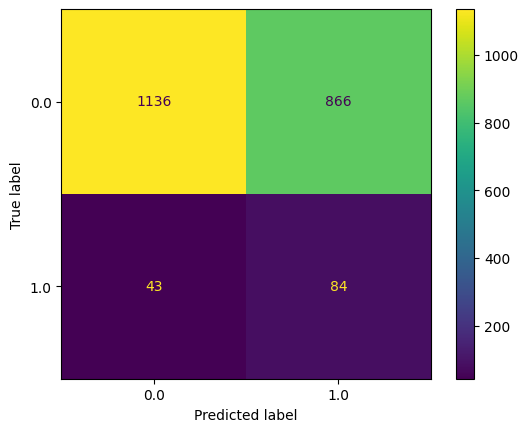

In [66]:
# Display confusion matrix
cm_lr_after = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_after, display_labels=model_lr_downsampled.classes_)
disp.plot()

plt.show()

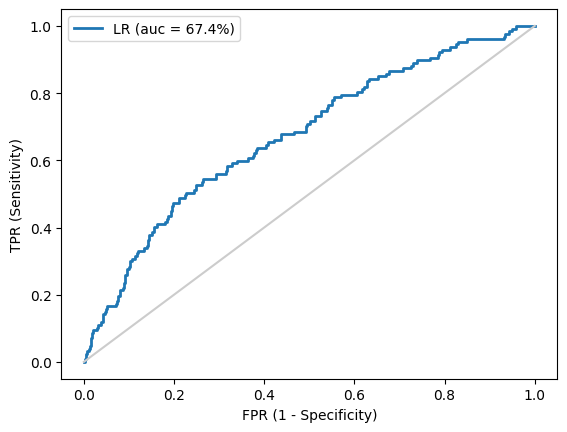

In [67]:
# ROC
fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr_after])

## 5. Feature Importance

In [68]:
# Calculate feature importance
feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

feature_importance

array([ 72.39555802,   8.3024505 ,   9.49612496,   4.36045828,
       100.        ,  14.69093488,  15.20877987,  27.0965561 ,
        26.57871111,  48.53885101,  27.61345308,   8.47253006,
        12.97071285,  17.64515171,  13.23949634,   3.88781038,
        23.79855675,   7.75654661,  16.55985512,  16.01096713,
        47.30735877,  31.81423663,   1.66227584,   0.1671854 ,
         2.34730623,   4.38489743,   4.90274242,  15.10947478,
        14.59162979,  54.06813077,  47.34863175,   6.20165403,
        64.58076939,  64.0629244 ,  33.23005027,  24.6619423 ,
        45.79480911,  16.87291856,  59.96252066,  17.26980827,
         9.54233215,  29.93522407,  21.24396067,   6.57052575,
        57.47720761,  12.44357362,  12.96141861])

In [69]:
# Custom function for Feature Importance for LR
import numpy as np

def plot_feature_importance_lr(lr_model, colnames_x, threshold_importance=None):
    # Compute feature importance
    feature_importance = abs(lr_model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    # Keep strong importance
    if threshold_importance is not None:
        feature_importance = feature_importance[feature_importance > threshold_importance]

    # Plot importance
    idx_sorted = np.argsort(feature_importance)
    pos = np.arange(idx_sorted.shape[0]) + 0.5

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.barh(pos, feature_importance[idx_sorted], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(np.array(X.columns)[idx_sorted], fontsize=12)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()   
    plt.show()

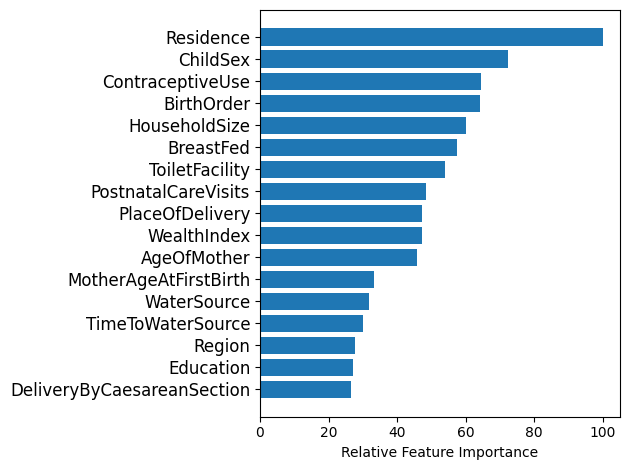

In [70]:
plot_feature_importance_lr(model_lr, colnames_x=X_train_ready.columns, threshold_importance=25)

In [71]:
# Save model for later use   ##################################################################################################################

# Import library
import joblib

# Save model
filepath_model = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\model_lr.pkl'
joblib.dump(model_lr_downsampled, 'model_lr.pkl')

['model_lr.pkl']

# 6. Load saved model and do predictions

In [72]:
# Load saved model
filepath_saved_model = r'D:\PycharmProjects\udemy-dhs-ai-framework-course\dhs_ai_framework_course\notebooks\model_lr.pkl'
loaded_model = joblib.load(filepath_saved_model)

In [73]:
loaded_model

LogisticRegression(max_iter=1000, random_state=101)

In [74]:
# Do prediction
y_pred = loaded_model.predict(X_val_ready)

In [75]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.])

In [76]:
len(y_pred)

2129

In [77]:
np.unique(y_pred, return_counts=True)

(array([0., 1.]), array([1179,  950], dtype=int64))